In [1]:
import jax.numpy as jnp
from utils_v2 import KalmanFilter
import math
import matplotlib.pyplot as plt
import jax.random as jrandom
from time import time

In [2]:
sigma_x = 0.01
sigma_t = 0.01
x_values = jnp.arange(0, 1, sigma_x)
t_values = jnp.arange(0, 2, sigma_t)
N = len(x_values)
M = len(t_values)
v = 0.001

In [3]:
N

100

In [4]:
u = jnp.sin(x_values * 2 * math.pi)
f = jnp.cos(x_values * 4 * math.pi)
nu = jnp.zeros(x_values.shape)

In [5]:
x_0 = jnp.expand_dims(jnp.r_[u, f, nu], axis=-1)

In [6]:
X = -2 * jnp.ones(u.shape[0])
X = jnp.diag(X)
X += jnp.diag(jnp.ones(u.shape[0] - 1), k=-1) + jnp.diag(jnp.ones(u.shape[0] - 1), k=1)
X /= sigma_x**2


In [7]:
INVS = jnp.linalg.inv(jnp.eye(X.shape[0]) - 0.5 * sigma_t * v * X)

In [8]:
A_n = INVS @ (jnp.eye(X.shape[0]) + 0.5 * sigma_t * v * X)

In [9]:
B_n = INVS * 0.5 * sigma_t

In [10]:
A_n.shape

(100, 100)

In [11]:
eye = jnp.eye(f.shape[0])
zero = jnp.zeros((f.shape[0], f.shape[0]))
A = jnp.block([[A_n, zero, zero], [zero, eye, zero], [zero, zero, eye]])

In [12]:
H = jnp.block(
    [
        eye,
        eye,
        eye,
    ]
)
R = jnp.eye(u.shape[0]) * 0.01
Q = jnp.eye(u.shape[0]) * 0.01

P_0 = jnp.ones((u.shape[0], u.shape[0]))

In [39]:
def plot(kf: KalmanFilter, iterations: int, plot_each: int = None) -> None:
    plot_each = iterations if plot_each is None else plot_each
    plot_each = min(plot_each, iterations)
    fig, ax = plt.subplots()
    ax.plot(x_values, f, label="True state")
    # ax[1].plot(x_values, nu, label="True state")
    kf.K = jnp.zeros((kf.H.shape[1], kf.H.shape[0]))
    for i in range(1, iterations + 1):
        kf.predict(kf.K @ kf.x_k)
        kf.update(jnp.expand_dims(f, axis=-1))
        if i % plot_each == 0:
            ax.plot(
                x_values,
                kf.x_k,
                label=f"KF estimation after {i} iterations",
            )
            # ax[1].plot(x_values,kf.x_k[2*N : 3 * N],label=f"nu KF estimation after {i} iterations",)

    plt.xlabel("x_n values", fontsize=15)
    plt.ylabel("f_n values", fontsize=15)
    plt.title("Training evolution", fontsize=15)
    ax.legend(fontsize=15)
    fig.set_size_inches(17, 10, forward=True)
    plt.show()


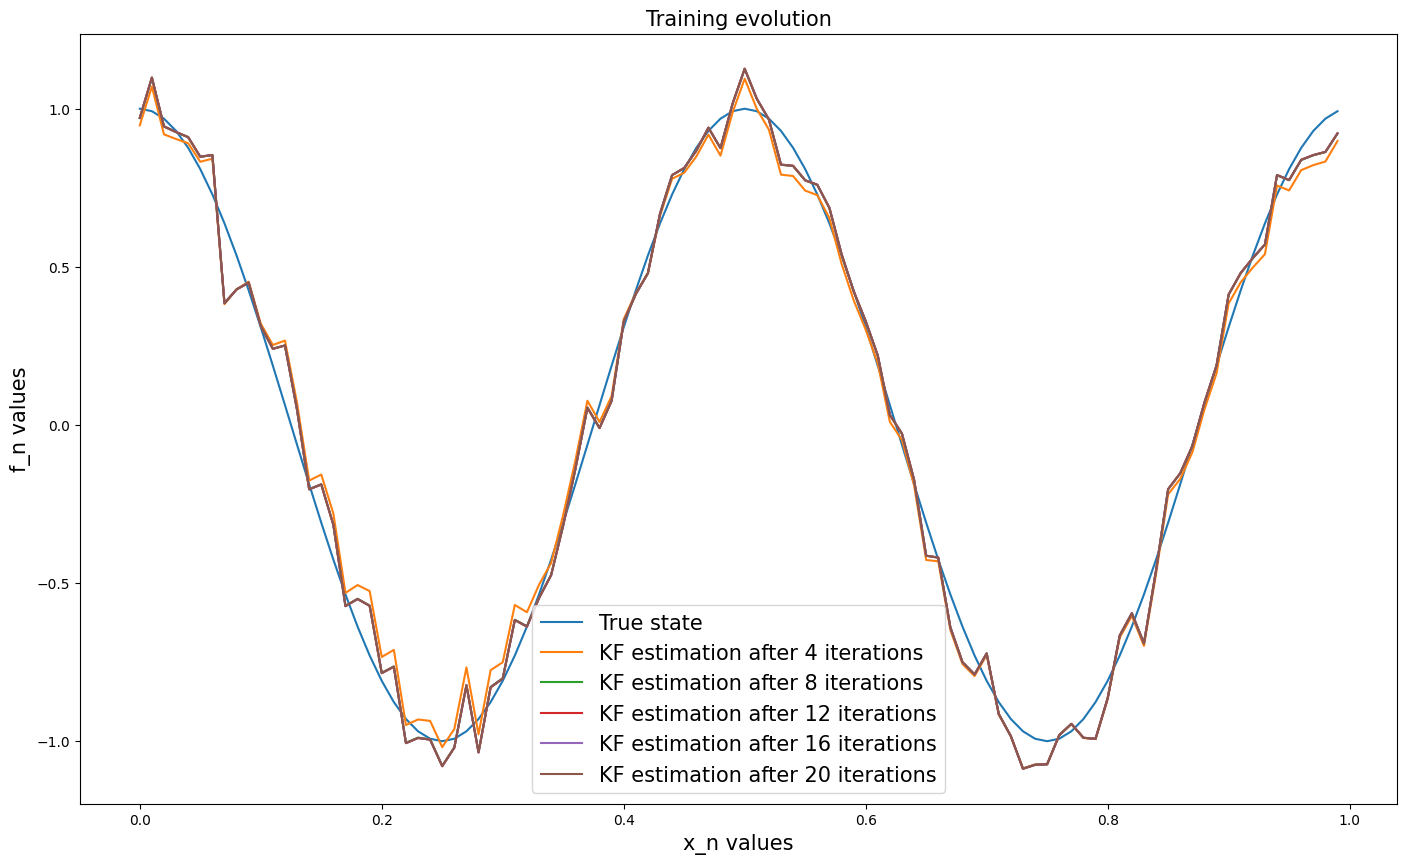

In [40]:
mean = 0
std_dev = 0.05
key = jrandom.PRNGKey(int(time()))
w_k = jrandom.normal(key, shape=(u.shape[0], 1)) * std_dev + mean
key = jrandom.PRNGKey(int(time()))
Z = jrandom.normal(key, shape=(u.shape[0], 1)) * std_dev + mean
kf = KalmanFilter(u, A_n, B_n, eye, eye, R, Q, Z, w_k, P_0)

plot(kf, iterations=20, plot_each=4)

In [35]:
kf.K

Array([[ 5.8271080e-01,  1.5697148e-02,  1.2524779e-03, ...,
         4.3636455e-19,  3.7754221e-19,  2.3220188e-19],
       [ 1.5697151e-02,  5.8396333e-01,  1.5742643e-02, ...,
         1.5521906e-19,  1.3501188e-19,  8.3328055e-20],
       [ 1.2524776e-03,  1.5742645e-02,  5.8396167e-01, ...,
         3.1578318e-19,  2.7387751e-19,  1.6871507e-19],
       ...,
       [ 1.5348134e-20,  2.5107090e-20,  2.9068452e-20, ...,
         5.8396178e-01,  1.5742643e-02,  1.2524779e-03],
       [-2.8292750e-20, -4.5905328e-20, -5.3086888e-20, ...,
         1.5742641e-02,  5.8396339e-01,  1.5697148e-02],
       [ 1.9035164e-19,  3.0974608e-19,  3.5837135e-19, ...,
         1.2524780e-03,  1.5697146e-02,  5.8271092e-01]], dtype=float32)